In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.models import MultipleIndependentOutputsGP
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.test_functions import *

from jax.scipy.stats import norm
import jaxbo.acquisitions as acquisitions

onp.random.seed(1234)


In [2]:
# Example from 
# https://dash.harvard.edu/bitstream/handle/1/17467236/GELBART-DISSERTATION-2015.pdf?sequence=4&isAllowed=y
# Page 74, section 6.2.3 

# Objective: f = x1 + x2
# Constraint1: g1 = 0.5*sin(2*pi*(x1^2 - 2*x2)) + x1 + 2*x2 - 1.5 >= 0
# Constraint2: g2 = -x1^2 - x2^2 + 1.5


def f(x):
    x1, x2 = x[0], x[1]
    f = x1 + x2
    return f


def constraint1(x):
    x1, x2 = x[0], x[1]
    g1 = 0.5*np.sin(2*np.pi*(x1**2 - 2.*x2)) + x1 + 2*x2 - 1.5
    return g1

def constraint2(x):
    x1, x2 = x[0], x[1]
    g2 = -x1**2 - x2**2 + 1.5
    return g2



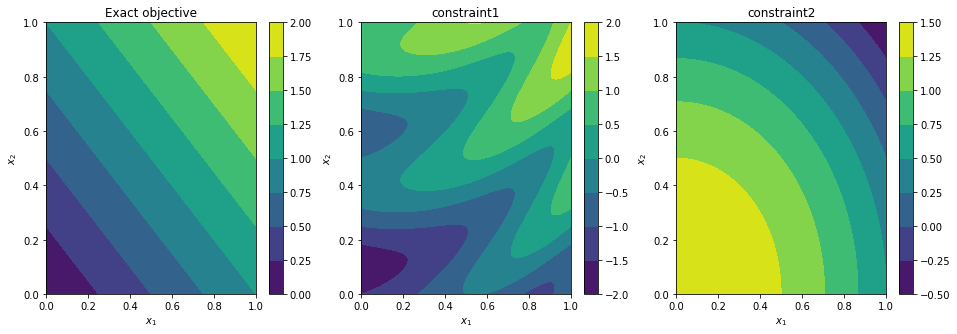

In [3]:
# Dimension of the problem
dim = 2

# Boundary of the domain
lb = 0.*np.ones(dim)
ub = 1.*np.ones(dim)

bounds = {'lb': lb, 'ub': ub}

# Visualization of the function and constraints in 2D grid
nn = 100
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], 
                         YY.flatten()[:,None]], axis = 1)
y_f_star = vmap(f)(X_star)

y1_c_star = vmap(constraint1)(X_star)
y2_c_star = vmap(constraint2)(X_star)

Y_f_star = griddata(onp.array(X_star), onp.array(y_f_star), (onp.array(XX), onp.array(YY)), method='cubic')
Y1_c_star = griddata(onp.array(X_star), onp.array(y1_c_star), (onp.array(XX), onp.array(YY)), method='cubic')
Y2_c_star = griddata(onp.array(X_star), onp.array(y2_c_star), (onp.array(XX), onp.array(YY)), method='cubic')


plt.figure(figsize = (16, 5))
plt.subplot(1, 3, 1)
fig = plt.contourf(XX, YY, Y_f_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact objective')
plt.colorbar(fig)

plt.subplot(1, 3, 2)
fig = plt.contourf(XX, YY, Y1_c_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'constraint1')
plt.colorbar(fig)

plt.subplot(1, 3, 3)
fig = plt.contourf(XX, YY, Y2_c_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'constraint2')
plt.colorbar(fig)



best y 0.6060606060606061 best x [0.2020202 0.4040404]


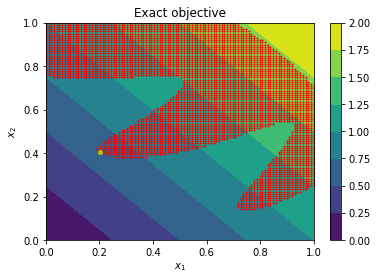

In [4]:
# Visualize the feasible domain and the location of the best value of this problem

judge1 = (y1_c_star >= 0)
judge2 = (y2_c_star >= 0)

total_judge = judge1 * judge2

valid_index = np.where(total_judge)
#print(valid_index)

valid_x = X_star[valid_index]
valid_y = y_f_star[valid_index]

#print(valid_x.shape, valid_y.shape)
idx_best = np.argmin(valid_y)
x_best = valid_x[idx_best]
y_best = valid_y[idx_best]

plt.figure(figsize = (6,4))
fig = plt.contourf(XX, YY, Y_f_star)
plt.plot(valid_x[:,0], valid_x[:, 1], 'r.', markersize = 2.)
plt.plot(x_best[0], x_best[1], 'y.', markersize = 8.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact objective')
plt.colorbar(fig)

print("best y", y_best, "best x", x_best)

true_x = x_best
true_y = y_best


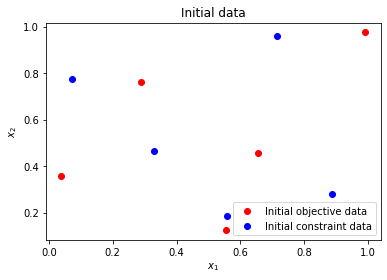

In [5]:
# Problem settings

# Number of initial data for objective and constraints
N_f = 5
N_c = 5
noise_f = 0.02
noise_c = 0.02

# JAX-BO setting
options = {'kernel': 'RBF',
           'criterion':'LCBC', #'EIC', 
           'input_prior': None,
           'kappa': 2.0,
           'nIter': 30}

gp_model = MultipleIndependentOutputsGP(options)

# Domain bounds (already defined before where we visualized the data)
bounds = {'lb': lb, 'ub': ub}


# Initial training data for objective
X_f = lb + (ub-lb)*lhs(dim, N_f)
y_f = vmap(f)(X_f)
y_f = y_f + noise_f*y_f_star.std(0)*onp.random.normal(0, 1, size=y_f.shape)

# Initial training data for constraints
X_c = lb + (ub-lb)*lhs(dim, N_c)
y1_c = vmap(constraint1)(X_c)
y1_c = y1_c + noise_c*y1_c_star.std(0)*onp.random.normal(0, 1, size=y1_c.shape)

y2_c = vmap(constraint2)(X_c)
y2_c = y2_c + noise_c*y2_c_star.std(0)*onp.random.normal(0, 1, size=y2_c.shape)

# Visualize the initial data for objective and constraints

plt.figure(figsize = (6,4))
plt.plot(X_f[:,0], X_f[:,1], 'ro', label = "Initial objective data")
plt.plot(X_c[:,0], X_c[:,1], 'bo', label = "Initial constraint data")
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Initial data')
plt.legend()


In [6]:
# Main Bayesian optimization loop
rng_key = random.PRNGKey(0)
for it in range(options['nIter']):
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, options['nIter']))
    print('-------------------------------------------------------------------')

    # Fetch normalized training data (for objective and all the constraints)
    norm_batch_f, norm_const_f = normalize(X_f, y_f, bounds)
    norm_batch_c1, norm_const_c1 = normalize(X_c, y1_c, bounds)
    norm_batch_c2, norm_const_c2 = normalize(X_c, y2_c, bounds)

    # Define a list using the normalized data and the normalizing constants
    norm_batch_list = [norm_batch_f, norm_batch_c1, norm_batch_c2]
    norm_const_list = [norm_const_f, norm_const_c1, norm_const_c2]


    # Train GP model with 30 random restart
    print('Train GP...')
    rng_key = random.split(rng_key, 2)[0]
    opt_params_list = gp_model.train(norm_batch_list,
                                     rng_key,
                                     num_restarts = 30)

    # Find the next acquisition point with 50 random restart
    print('Computing next acquisition point...')
    kwargs = {'params': opt_params_list,
              'batch': norm_batch_list,
              'norm_const': norm_const_list,
              'bounds': bounds,
              'kappa': options['kappa'],
              'gmm_vars': None}
    new_X = gp_model.compute_next_point_lbfgs(num_restarts=50, **kwargs)

    # Acquire data
    # New objective data 
    new_y_f = vmap(f)(new_X) # This is the output of the solver for generating the objective function
    new_y_f = new_y_f + noise_f*y_f_star.std(0)*onp.random.normal(new_y_f.shape)

    # New constraint1 data 
    new_y1_c = vmap(constraint1)(new_X) # This is the output of the solver for generating the constraint1 functions
    new_y1_c = new_y1_c + noise_c*y1_c_star.std(0)*onp.random.normal(new_y1_c.shape)

    # New constraint2 data
    new_y2_c = vmap(constraint2)(new_X) # This is the output of the solver for generating the constraint2 functions
    new_y2_c = new_y2_c + noise_c*y2_c_star.std(0)*onp.random.normal(new_y2_c.shape)


    # Augment training data
    print('Updating data-set...')
    X_f = np.concatenate([X_f, new_X], axis = 0)
    X_c = np.concatenate([X_c, new_X], axis = 0)

    y_f = np.concatenate([y_f, new_y_f], axis = 0)
    y1_c = np.concatenate([y1_c, new_y1_c], axis = 0)
    y2_c = np.concatenate([y2_c, new_y2_c], axis = 0)


    # Print current best
    print('True location: ({}), True value: {}'.format(true_x, true_y))
    print('New  location: ({}), New  value: {}'.format(new_X, new_y_f))
    
    

-------------------------------------------------------------------
------------------------- Iteration 1/30 -------------------------
-------------------------------------------------------------------
Train GP...
Computing next acquisition point...
Updating data-set...
True location: ([0.2020202 0.4040404]), True value: 0.6060606060606061
New  location: ([[0.23711979 0.46330584]]), New  value: [0.69156026]
-------------------------------------------------------------------
------------------------- Iteration 2/30 -------------------------
-------------------------------------------------------------------
Train GP...
Computing next acquisition point...
Updating data-set...
True location: ([0.2020202 0.4040404]), True value: 0.6060606060606061
New  location: ([[0.30442665 0.46335463]]), New  value: [0.78220925]
-------------------------------------------------------------------
------------------------- Iteration 3/30 -------------------------
-----------------------------------------

Computing next acquisition point...
Updating data-set...
True location: ([0.2020202 0.4040404]), True value: 0.6060606060606061
New  location: ([[0.24570954 0.394973  ]]), New  value: [0.6482549]
-------------------------------------------------------------------
------------------------- Iteration 22/30 -------------------------
-------------------------------------------------------------------
Train GP...
Computing next acquisition point...
Updating data-set...
True location: ([0.2020202 0.4040404]), True value: 0.6060606060606061
New  location: ([[0.24611768 0.3953801 ]]), New  value: [0.63395108]
-------------------------------------------------------------------
------------------------- Iteration 23/30 -------------------------
-------------------------------------------------------------------
Train GP...
Computing next acquisition point...
Updating data-set...
True location: ([0.2020202 0.4040404]), True value: 0.6060606060606061
New  location: ([[0.2453995  0.39509104]]), New

In [7]:
# Visualize the final outputs 

kwargs = {'params': opt_params_list,
          'batch': norm_batch_list,
          'norm_const': norm_const_list,
          'bounds': bounds,
          'kappa': gp_model.options['kappa']}

# Making prediction on the posterior objective and all constraints
mean, std = gp_model.predict(X_star, **kwargs)

# Compute the upper and lower bounds of the posterior distributions
lower = mean - 2.0*std
upper = mean + 2.0*std

print(mean.shape, std.shape, lower.shape, upper.shape)


(3, 10000) (3, 10000) (3, 10000) (3, 10000)


In [8]:
# Evaluate the acquisition function
acq_fn1 = lambda x: gp_model.acquisition(x, **kwargs)
LCBCacq = vmap(acq_fn1)(X_star)

# Compute the ratio and weights derived by the constraints and convert everything into numpy for plotting
ratio1 = mean[1,:] / std[1,:]
ratio2 = mean[2,:] / std[2,:]

weight1 = norm.cdf(mean[1,:]/std[1,:])
weight2 = norm.cdf(mean[2,:]/std[2,:])

LCBCacq = onp.array(LCBCacq)

mean = onp.array(mean)
std = onp.array(std)

ratio1 = onp.array(ratio1)
ratio2 = onp.array(ratio2)

weight1 = onp.array(weight1)
weight2 = onp.array(weight2)

y_f_pred = onp.array(mean[0,:])
y1_c_pred = onp.array(mean[1,:])
y2_c_pred = onp.array(mean[2,:])

y_f_std = onp.array(std[0,:])



0.7030458828189798 0.27549331515963416


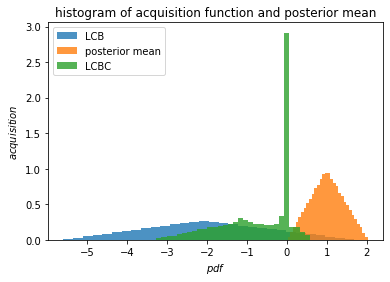

In [9]:
# Check if the main part of LCB is negative (not a part of the tutorial could be ignored)

mu_y = norm_const_list[0]['mu_y']
sigma_y = norm_const_list[0]['sigma_y']
kappa = 2.0

print(mu_y, sigma_y)

plt.figure(figsize = (6,4))
plt.hist((y_f_pred - mu_y) / sigma_y - 3.0 - kappa*y_f_std/sigma_y, density = True, bins = 30, label = "LCB", alpha = 0.8)
plt.hist(y_f_pred, density = True, bins = 30, label = "posterior mean", alpha = 0.8)
plt.hist(LCBCacq.flatten(), density = True, bins = 30, label = "LCBC", alpha = 0.8)
plt.xlabel(r'$pdf$')
plt.ylabel(r'$acquisition$')
plt.title(r'histogram of acquisition function and posterior mean')
plt.legend()


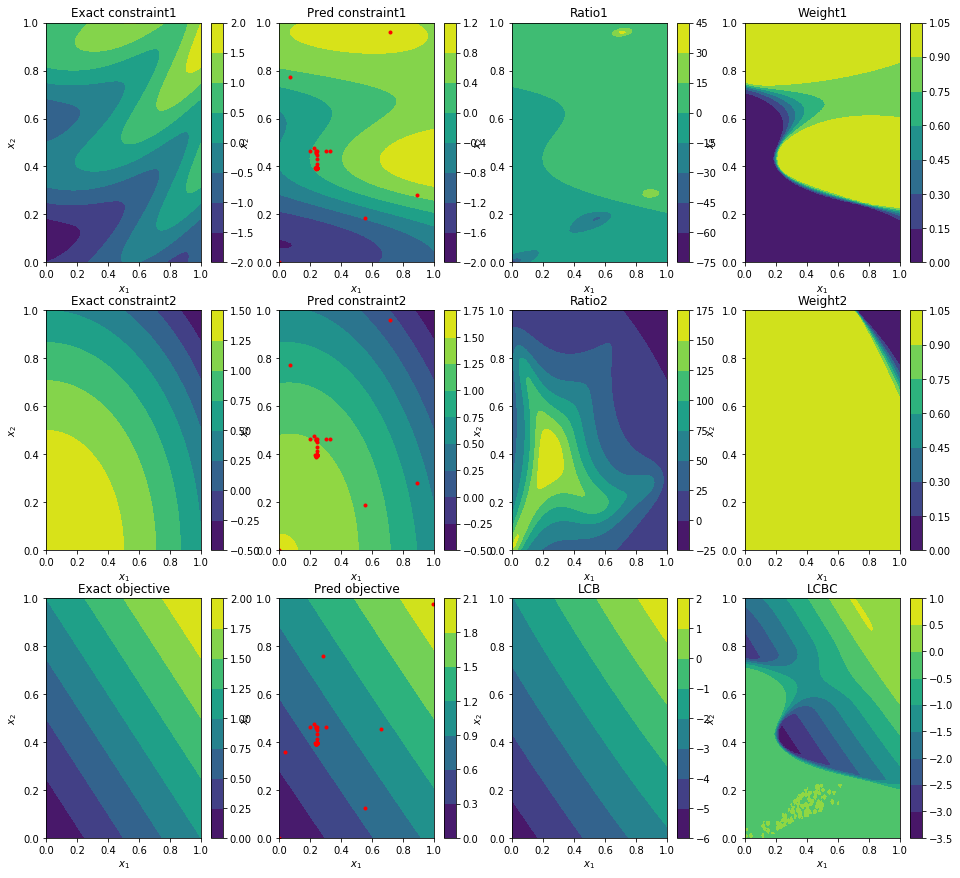

In [10]:
# Convert the numpy variable into grid data for visualization
Y_f_pred = griddata(onp.array(X_star), y_f_pred, (onp.array(XX), onp.array(YY)), method='cubic')
Y1_c_pred = griddata(onp.array(X_star), y1_c_pred, (onp.array(XX), onp.array(YY)), method='cubic')
Y2_c_pred = griddata(onp.array(X_star), y2_c_pred, (onp.array(XX), onp.array(YY)), method='cubic')

Y_f_std = griddata(onp.array(X_star), y_f_std, (onp.array(XX), onp.array(YY)), method='cubic')

Ratio1 = griddata(onp.array(X_star), ratio1, (onp.array(XX), onp.array(YY)), method='cubic')
Ratio2 = griddata(onp.array(X_star), ratio2, (onp.array(XX), onp.array(YY)), method='cubic')

Weight1 = griddata(onp.array(X_star), weight1, (onp.array(XX), onp.array(YY)), method='cubic')
Weight2 = griddata(onp.array(X_star), weight2, (onp.array(XX), onp.array(YY)), method='cubic')

LCBCacq = griddata(onp.array(X_star), LCBCacq.flatten(), (onp.array(XX), onp.array(YY)), method='cubic')

LCBacq = (Y_f_pred - mu_y) / sigma_y - 3. - kappa*Y_f_std/sigma_y


# Visualization
plt.figure(figsize = (16,15))
plt.subplot(3, 4, 1)
fig = plt.contourf(XX, YY, Y1_c_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact constraint1')
plt.colorbar(fig)

plt.subplot(3, 4, 2)
fig = plt.contourf(XX, YY, Y1_c_pred)
plt.plot(X_c[:,0], X_c[:,1], 'r.')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Pred constraint1')
plt.colorbar(fig)

plt.subplot(3, 4, 3)
fig = plt.contourf(XX, YY, Ratio1)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Ratio1')
plt.colorbar(fig)


plt.subplot(3, 4, 4)
fig = plt.contourf(XX, YY, np.clip(Weight1, 0, np.inf))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Weight1')
plt.colorbar(fig)


plt.subplot(3, 4, 5)
fig = plt.contourf(XX, YY, Y2_c_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact constraint2')
plt.colorbar(fig)

plt.subplot(3, 4, 6)
fig = plt.contourf(XX, YY, Y2_c_pred)
plt.plot(X_c[:,0], X_c[:,1], 'r.')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Pred constraint2')
plt.colorbar(fig)

plt.subplot(3, 4, 7)
fig = plt.contourf(XX, YY, Ratio2)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Ratio2')
plt.colorbar(fig)


plt.subplot(3, 4, 8)
fig = plt.contourf(XX, YY, Weight2)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Weight2')
plt.colorbar(fig)


plt.subplot(3, 4, 9)
fig = plt.contourf(XX, YY, Y_f_star)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact objective')
plt.colorbar(fig)

plt.subplot(3, 4, 10)
fig = plt.contourf(XX, YY, Y_f_pred)
plt.plot(X_f[:,0], X_f[:,1], 'r.')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Pred objective')
plt.colorbar(fig)

plt.subplot(3, 4, 11)
fig = plt.contourf(XX, YY, LCBacq)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'LCB')
plt.colorbar(fig)


plt.subplot(3, 4, 12)
fig = plt.contourf(XX, YY, LCBCacq)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'LCBC')
plt.colorbar(fig)





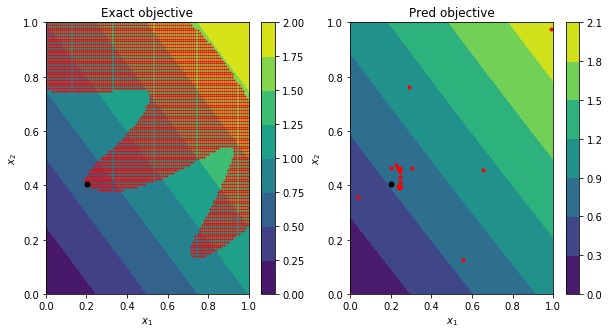

In [11]:
# Data we collected and the ground truth
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
fig = plt.contourf(XX, YY, Y_f_star)
plt.plot(valid_x[:,0], valid_x[:, 1], 'r.', markersize = 2.)
plt.plot(true_x[0], true_x[1], 'k.', markersize = 10.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Exact objective')
plt.colorbar(fig)


plt.subplot(1, 2, 2)
fig = plt.contourf(XX, YY, Y_f_pred)
plt.plot(X_f[:,0], X_f[:,1], 'r.')
plt.plot(true_x[0], true_x[1], 'k.', markersize = 10.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Pred objective')
plt.colorbar(fig)

